In [1]:
#imports
import logging
import torch
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression
import matplotlib.pyplot as plt

from sk_models import PLSRegression, StandardScaler,LocalWeightedRegression,PLSLWR,LinearRidge
from river_models import *

from river import stream,linear_model,preprocessing, ensemble, metrics, optim
from river.neighbors import KNNRegressor 
from sklearn.metrics import mean_squared_error
from river.utils import dict2numpy, numpy2dict

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and output directories

#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["db_id","sample_id"] #
output_cols = None
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/7.00") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\7.00\PLN7


In [3]:
data = pd.read_csv(data_file)
data=data.sample(frac=1,random_state=random_state)

pre_ind =[i for i in range(0,10000)]
pretrain_ind,pretest_ind = train_test_split(pre_ind,train_size=5/6,random_state=random_state,shuffle=False)
stream_ind = [i for i in range(10000,110000)]

pretrain_data =  ut.TabularDataset(data.iloc[pretrain_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
pretest_data = ut.TabularDataset(data.iloc[pretest_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
stream_data = ut.TabularDataset(data.iloc[stream_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
xi,yi = stream_data[87217-len(pretest_data)]
nrow, ncol = data.shape
nrow_train = len(pretrain_data)
nrow_test = len(pretest_data)
nrow_stream = len(stream_data)

print(f"train: {nrow_train}, test: {nrow_test}, stream: {nrow_stream}")

train: 8333, test: 1667, stream: 100000


In [4]:
deep_model_dir = Path("D:/workspace/lazydeep/experiments/1.01/PLN7")
pls_deep_model = torch.load(deep_model_dir/"models"/"random_82"/"_model")
pls_deep_model.load_state(deep_model_dir/"models"/"random_82"/"_final")
pls_scaler = PLSRegression(n_components=34).from_state(PLSRegression(n_components=34).load_state(deep_model_dir/'preprocessing'/f"_final"))                       
pls_deep_lwr = StreamLocalWeightedRegression(n_neighbors=1000,floor=True)


#stream_pls_deep = StreamDeep(pls_scaler,pls_deep_model)
#stream_pls_deep_lwr = StreamDeepLWR(pls_scaler,pls_deep_model,pls_deep_lwr)
stream_pls_deep = (StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model))
stream_pls_deep_lwr = (StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model)|StreamLocalWeightedRegression(n_neighbors=1000,floor=True))
                          
deep_model_dir = Path("D:/workspace/lazydeep/experiments/2.00/PLN7")
deep_model = torch.load(deep_model_dir/"models"/"random_25"/"_model")
deep_model.load_state(deep_model_dir/"models"/"random_25"/"_final")
deep_scaler = StandardScaler().from_state(StandardScaler().load_state(deep_model_dir/'preprocessing'/f"_final"))                
                      
deep_lwr = StreamLocalWeightedRegression(n_neighbors=1000,floor=True)

#stream_deep = StreamDeep(deep_scaler,deep_model)
#stream_deep_lwr = StreamDeepLWR(deep_scaler,deep_model,deep_lwr)
stream_deep = (StreamWrapper(deep_scaler)|StreamDeep(deep_model))
stream_deep_lwr = (StreamWrapper(deep_scaler)|StreamDeep(deep_model)|StreamLocalWeightedRegression(n_neighbors=1000,floor=True))



In [5]:
#pt one, lets look at our spectra

In [6]:
def split_fos(series):
    fos3 = series["FOS3"]
    series = series.drop("FOS3")
    return series,fos3

base_measures = stream_data.take_summary([i for i,(_,_) in enumerate(stream_data)])

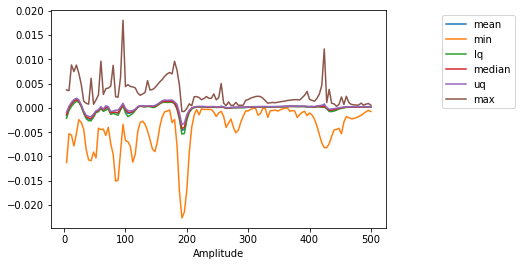

In [11]:
fig, ax = plt.subplots()

for k,v in base_measures.items():
    if not k == 'var':
        v1,_ = split_fos(v)
        x = [int(i.replace("amplitude-","")) for i in v1.index]
        ax.plot(x,v1,label=k)
xi1 = xi[0:len(xi)-1]
#ax.plot(xi1,label='outlier')
ax.set_xlabel("Amplitude")
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"base_quantile.png",bbox_inches='tight')

In [8]:
#now do our pls
stream_X,stream_y = stream_data[:]
pls_trans = pls_scaler.transform(stream_X)
std_trans = deep_scaler.transform(stream_X)
pls_deep_trans = pls_deep_model.compress(torch.Tensor(pls_trans)).detach().numpy()
deep_trans = deep_model.compress(torch.Tensor(std_trans)).detach().numpy()



In [23]:
pls_measures = ut.take_summary(pls_trans)
pls_xi = pls_scaler.transform([xi])[0]

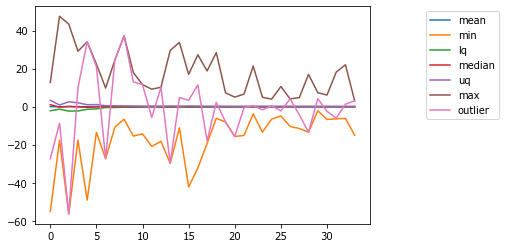

In [24]:
fig, ax = plt.subplots()

for k,v in pls_measures.items():
    if not k == 'var':
        ax.plot(v.index,v,label=k)
ax.plot(pls_xi,label='outlier')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"pls_quantile.png",bbox_inches='tight')

In [11]:
pls_deep_measures = ut.take_summary(pls_deep_trans)
pls_deep_xi =  pls_deep_model.compress(torch.Tensor(pls_scaler.transform([xi]))).detach().numpy()[0]

In [12]:
pls_deep_xi

array([ 5.3791666e+00,  7.9838428e+00, -2.0391529e+00,  2.5703068e+00,
       -5.2788228e-01,  5.3867579e-02,  1.3742550e+01,  4.2152619e+00,
       -1.1807141e+00,  9.5865532e+01, -1.7417904e+00, -7.0058078e-01,
        1.4024542e+01,  4.0709805e+00, -2.4865305e-01, -2.2586551e+00,
       -1.4481193e+00, -4.2589760e+00, -1.1730143e-01,  7.3841105e+00,
        9.1582603e+00, -3.7281537e+00,  3.3430448e+00, -3.6658118e+00,
        4.1816605e+01], dtype=float32)

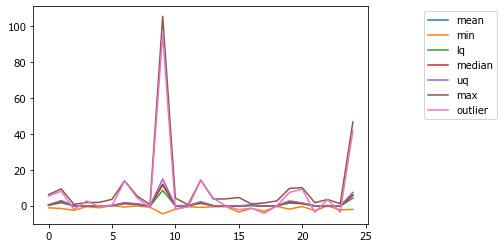

In [13]:
fig, ax = plt.subplots()

for k,v in pls_deep_measures.items():
    if not k == 'var':
        ax.plot(v.index,v,label=k)
ax.plot(pls_deep_xi,label="outlier")
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"pls_deep_quantile.png",bbox_inches='tight')

In [25]:
std_measures = ut.take_summary(std_trans)
std_xi = deep_scaler.transform([xi])[0]

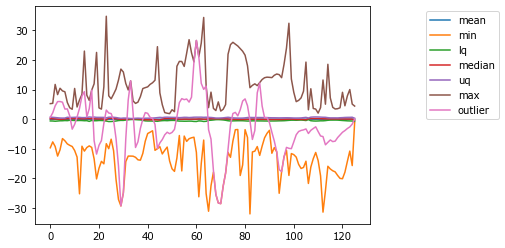

In [26]:
fig, ax = plt.subplots()

for k,v in std_measures.items():
    if not k == 'var':
        ax.plot(v.index,v,label=k)
ax.plot(std_xi,label="outlier")
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"std_quantile.png",bbox_inches='tight')

In [28]:
deep_measures = ut.take_summary(deep_trans)
deep_xi =  deep_model.compress(torch.Tensor(deep_scaler.transform([xi]))).detach().numpy()[0]

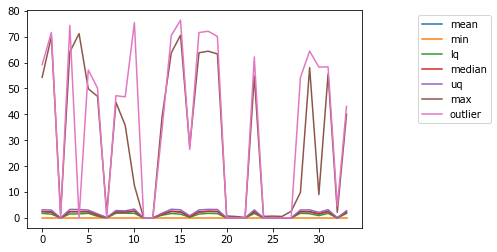

In [29]:
fig, ax = plt.subplots()

for k,v in deep_measures.items():
    if not k == 'var':
        ax.plot(v.index,v,label=k)
ax.plot(deep_xi,label="outlier")
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"std_deep_quantile.png",bbox_inches='tight')